# Data Visualization & Final Clean For ML

This notebook explores the **machine learning–ready dataset** obtained after all preprocessing steps and basic feature engineering.  
The purpose of this step is to gain deeper insights into the data structure and distributions before launching model training and optimization.

We will combine visual analysis and final adjustments to ensure the dataset is **robust, clean, and suitable for regression tasks**.


## Objectives of this step:

1. **Visualize the distribution of the target variable (`price`)**  
   - Detect skewness and outliers  
   - Assess the potential benefit of a log transformation

2. **Explore numerical and categorical feature distributions**  
   - Check for data imbalance, missing values, or abnormal patterns  
   - Confirm encoding consistency and value ranges

3. **Detect outliers or anomalies**  
   - Use scatterplots, boxplots, and conditional filtering  
   - Flag unusual combinations of features (e.g., very small surface but very high price)

4. **Analyze feature correlations**  
   - Correlation matrix and heatmap for numerical features  
   - Identify strong predictors of `price`  
   - Detect multicollinearity risks

5. **Perform final adjustments before modeling**  
   - Drop irrelevant or redundant features  
   - Optionally cap/fix outliers or re-scale skewed variables  
   - Confirm the dataset is clean, consistent, and aligned with model requirements


>Input: `ml_ready_dataset.csv`  
>Output: Exploratory plots and insights


In [56]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

# Load constants and helper paths
from utils.constants import CLEANED_DATA_FILE

# Load cleaned data to retrieve the target
df = pd.read_csv(CLEANED_DATA_FILE)
target = df["price"]

# --- Clean and order epcScore ---
from pandas.api.types import CategoricalDtype

valid_epc_labels = ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
df = df[df['epcScore'].isin(valid_epc_labels)]  # Drop invalid labels
epc_cat_type = CategoricalDtype(categories=valid_epc_labels, ordered=True)
df['epcScore'] = df['epcScore'].astype(epc_cat_type)

# --- Handle extreme values in price ---

# Apply log transformation to target price for better modeling
df['log_price'] = np.log1p(df['price'])  # log(1 + price) is safer for 0-values

# Remove extreme price outliers using the IQR method
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# --- Handle facade count ---

# Remove unrealistic facadeCount values (greater than 10)
df = df[df['facedeCount'] <= 10]  # Keep column name as 'facedeCount' with 'e'

# Impute or drop missing values in facedeCount
if df['facedeCount'].isnull().mean() > 0.3:
    df = df.drop(columns='facedeCount')  # <-- you forgot df =
else:
    df['facedeCount'] = df['facedeCount'].fillna(df['facedeCount'].median())

# --- Identify large properties ---
df['is_big_property'] = (df['habitableSurface'] > 1000).astype(int)

# Optionally remove extreme habitableSurface values
df = df[df['habitableSurface'] <= 1000]

# --- Feature engineering: surface per room ---
df['room_count'] = df['bedroomCount'] + df['bathroomCount']
df['surface_per_room'] = df['habitableSurface'] / df['room_count']
df['surface_per_room'] = df['surface_per_room'].replace([np.inf, -np.inf], np.nan)
df['surface_per_room'] = df['surface_per_room'].fillna(df['surface_per_room'].median())


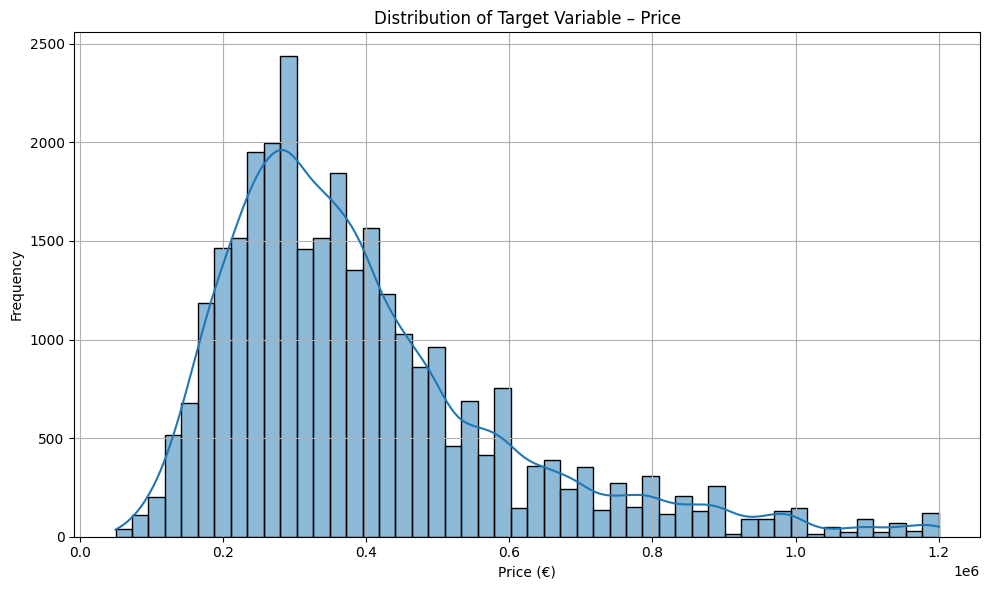

In [ ]:
# --- Distribution of target variable (price) ---
plt.figure(figsize=(10, 6))
sns.histplot(target, bins=50, kde=True)
plt.title("Distribution of Target Variable – Price")
plt.xlabel("Price (€)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

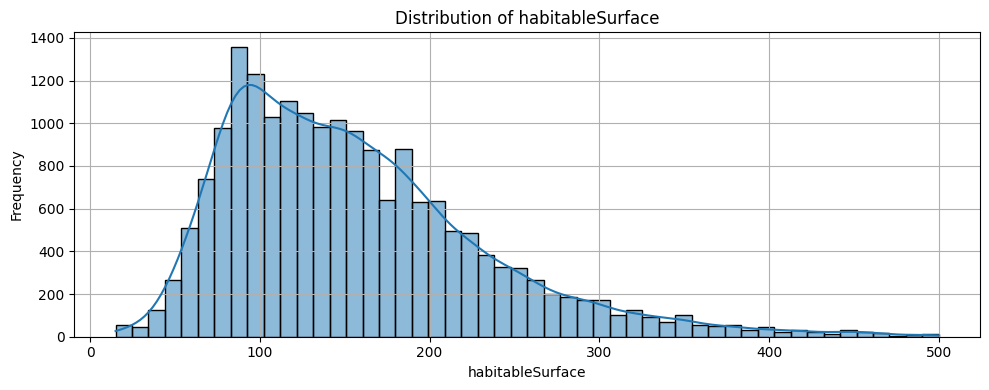

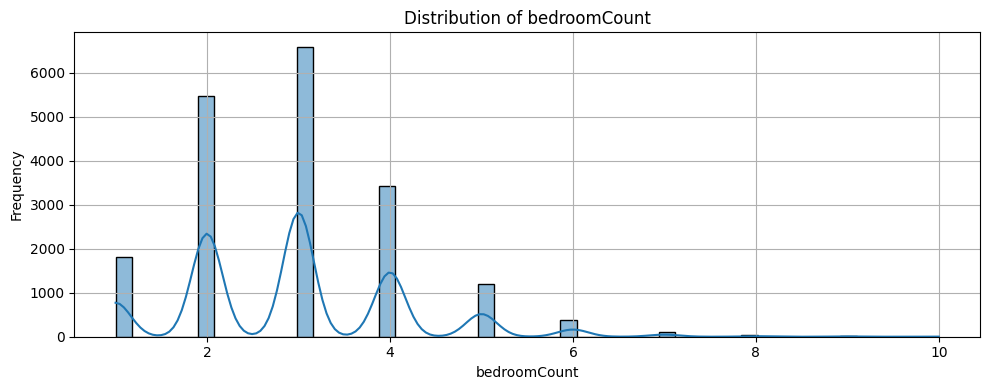

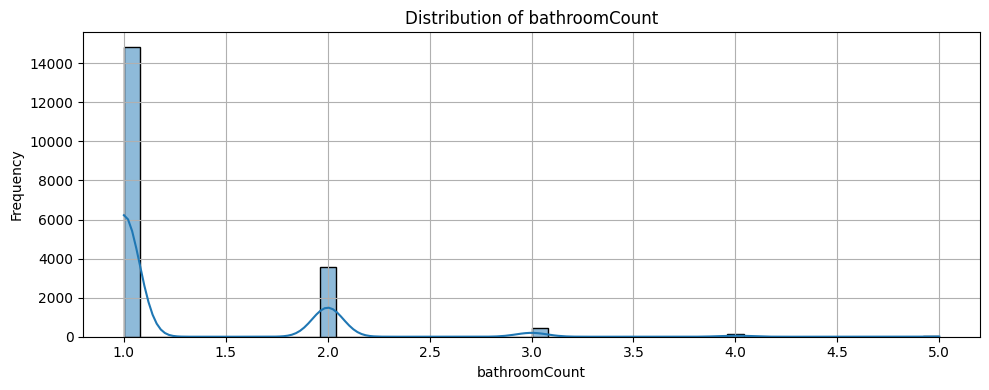

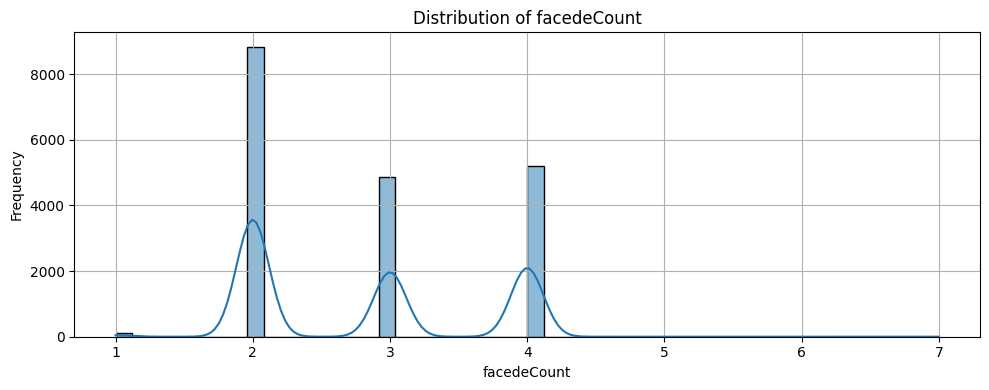

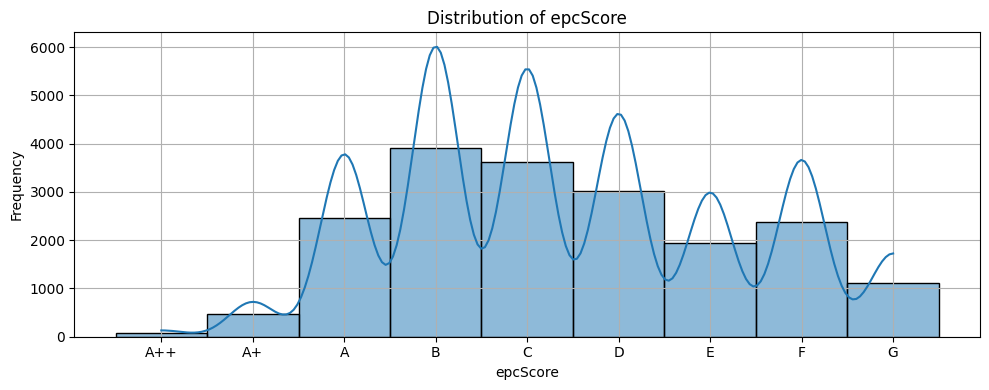

In [ ]:
# --- Distribution of numeric features ---
from matplotlib import pyplot as plt


numeric_cols = ["habitableSurface", "bedroomCount", "bathroomCount", "facedeCount", "epcScore"]

for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col].dropna(), bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


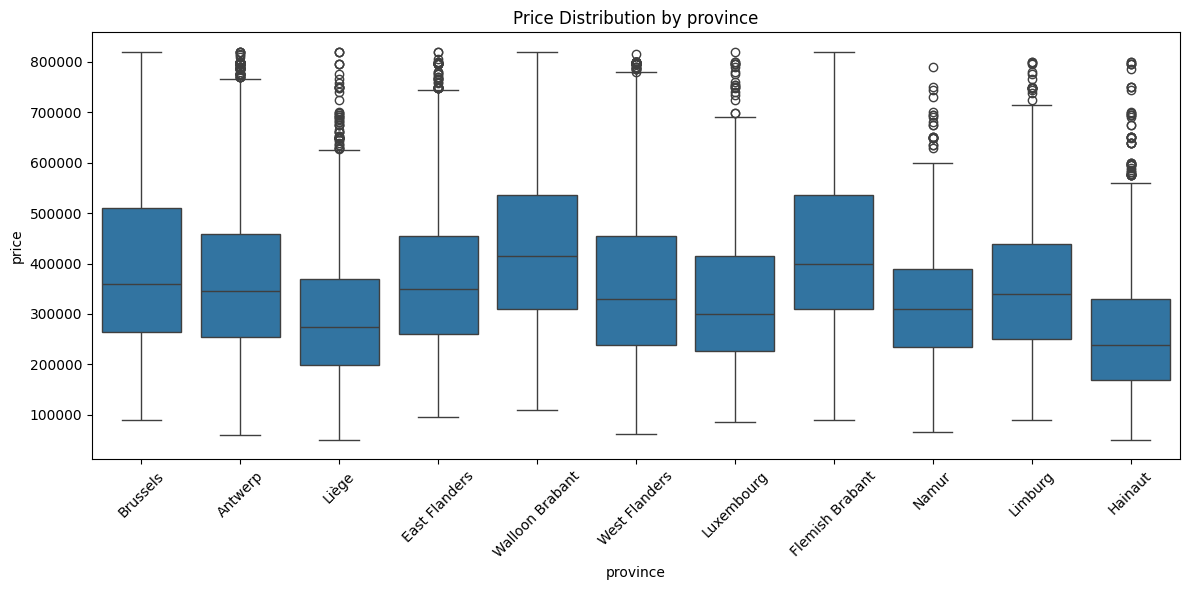

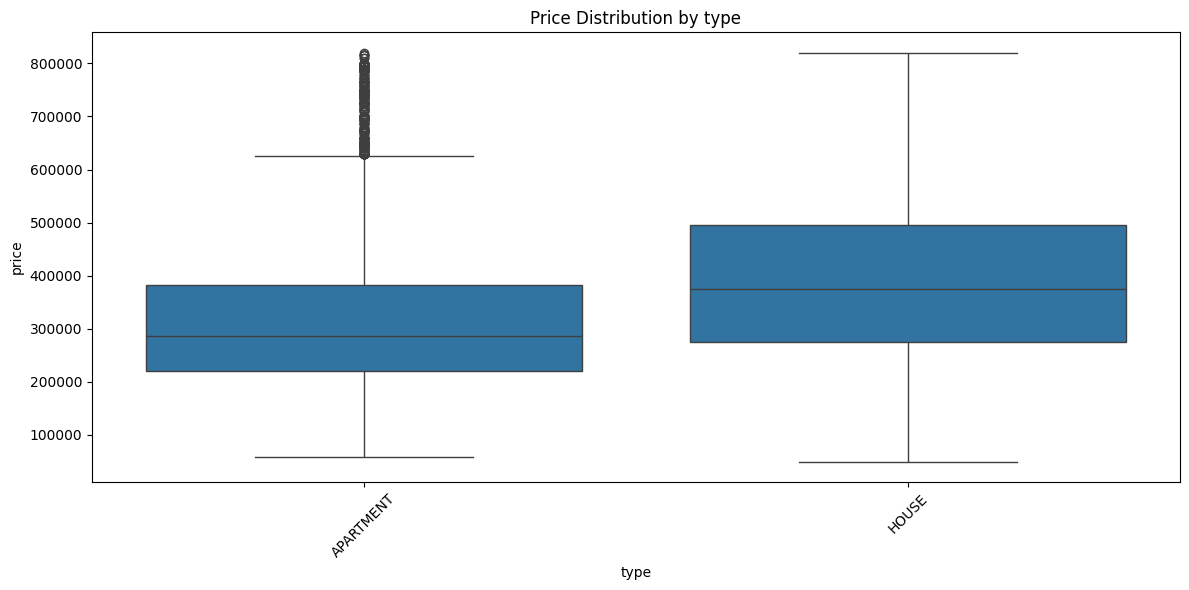

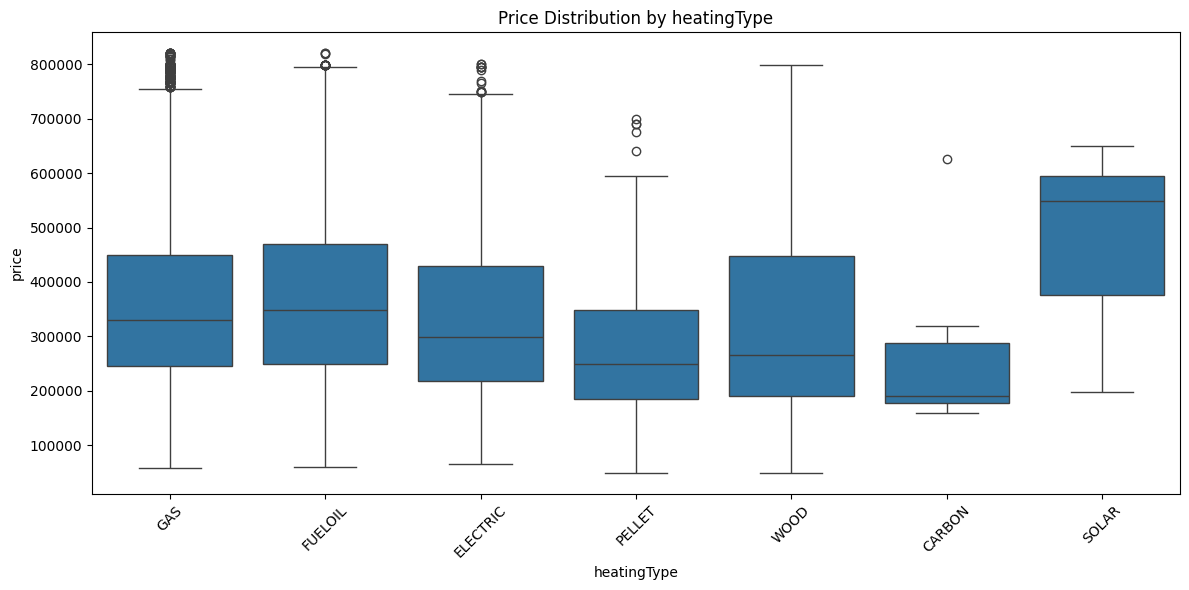

In [ ]:
# --- Boxplots for categorical features vs price ---
cat_cols = ["province", "type", "heatingType"]

for col in cat_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=col, y="price")
    plt.title(f"Price Distribution by {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


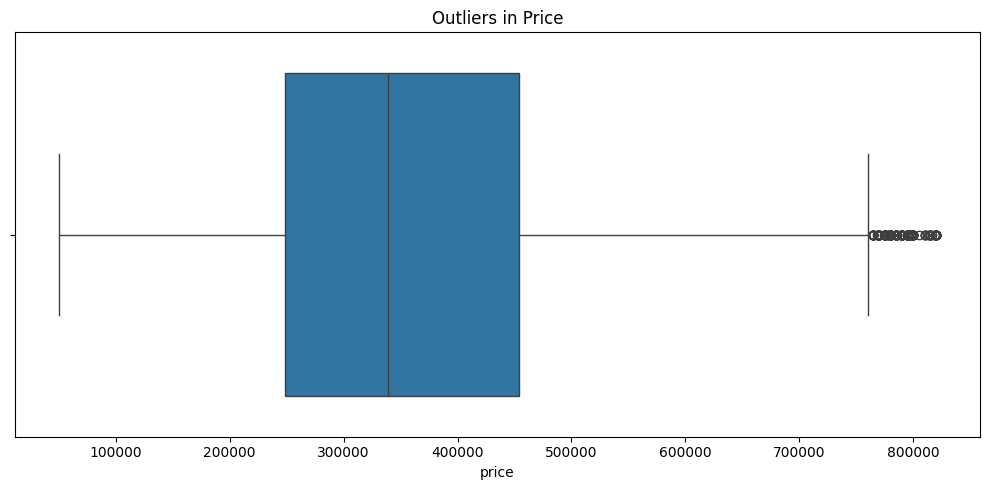

In [ ]:
# --- Boxplot for outliers in price ---
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["price"])
plt.title("Outliers in Price")
plt.tight_layout()
plt.show()


Numeric columns found: ['Unnamed: 0', 'id', 'bedroomCount', 'bathroomCount', 'postCode', 'habitableSurface', 'buildingConstructionYear', 'facedeCount', 'toiletCount', 'price', 'log_price', 'room_count', 'surface_per_room']


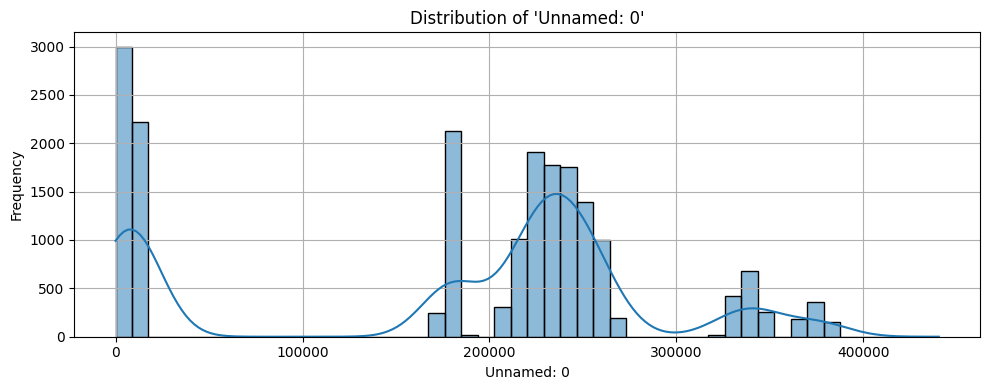

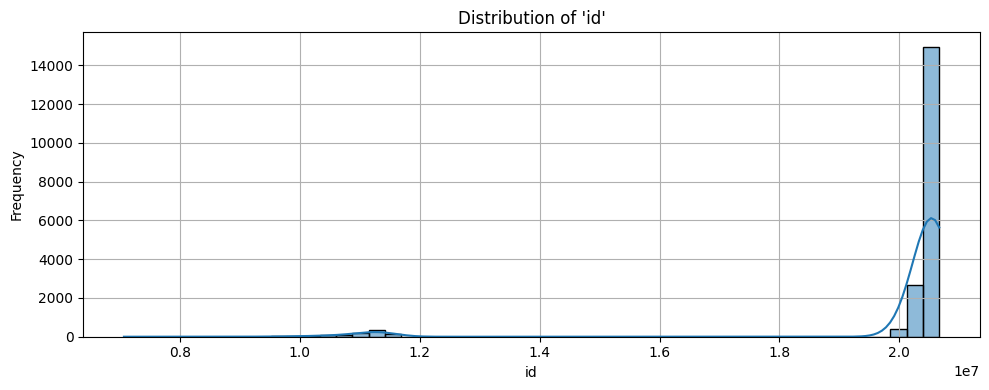

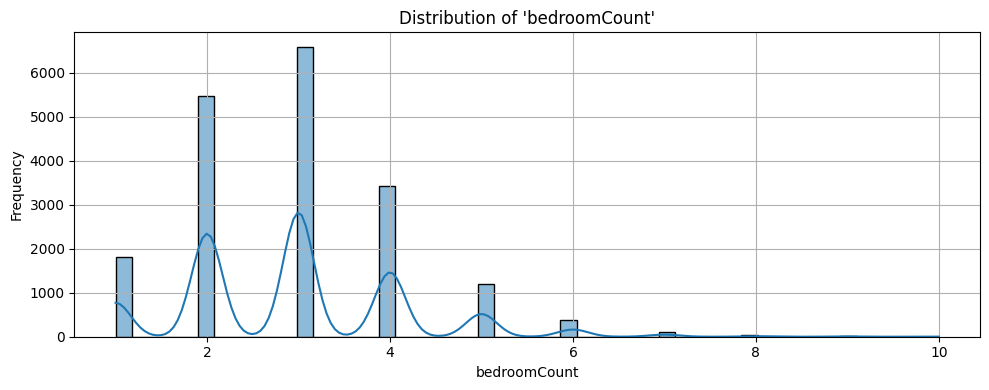

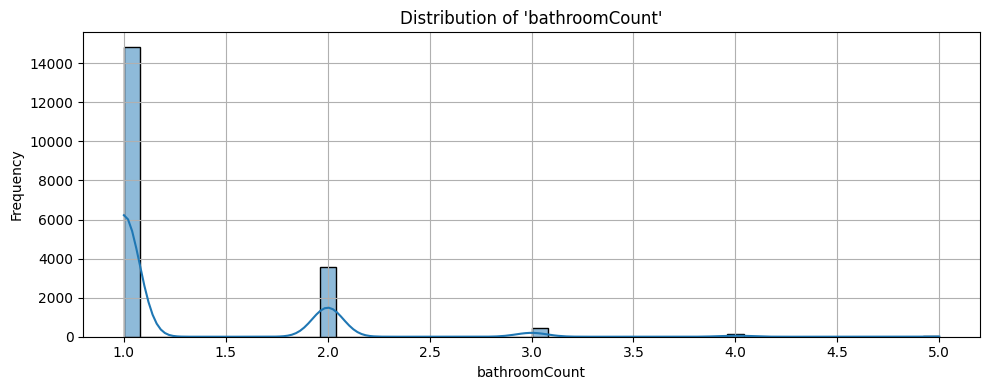

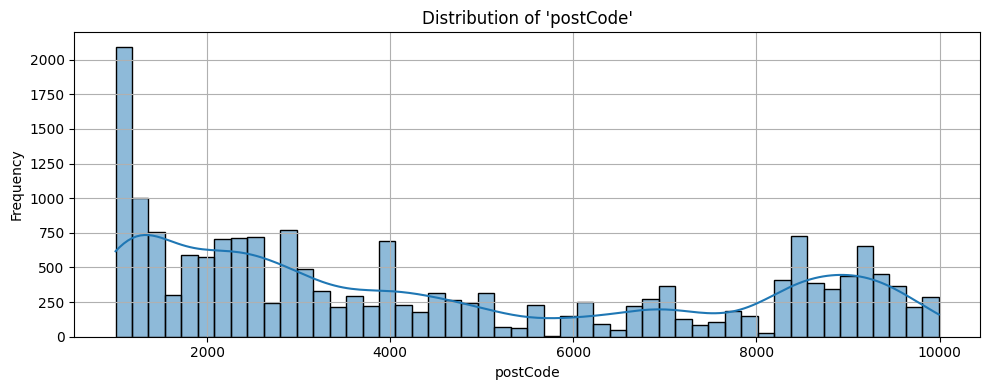

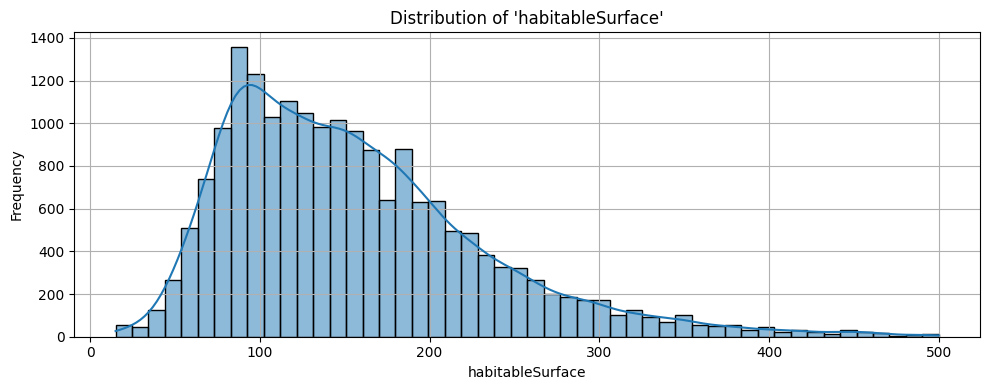

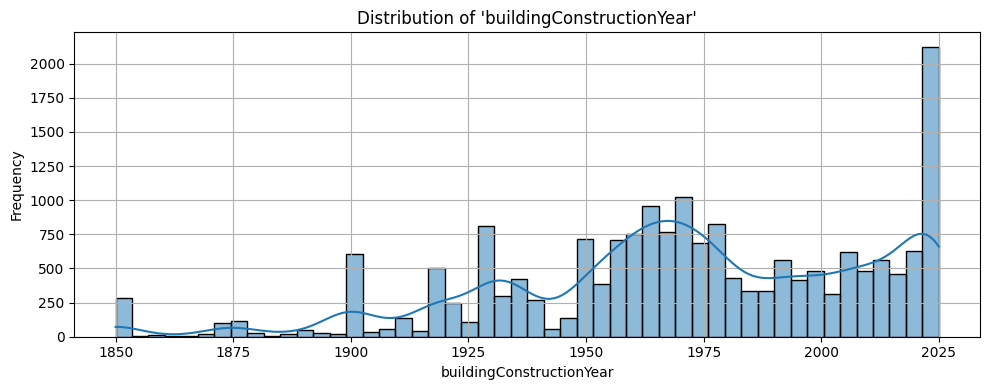

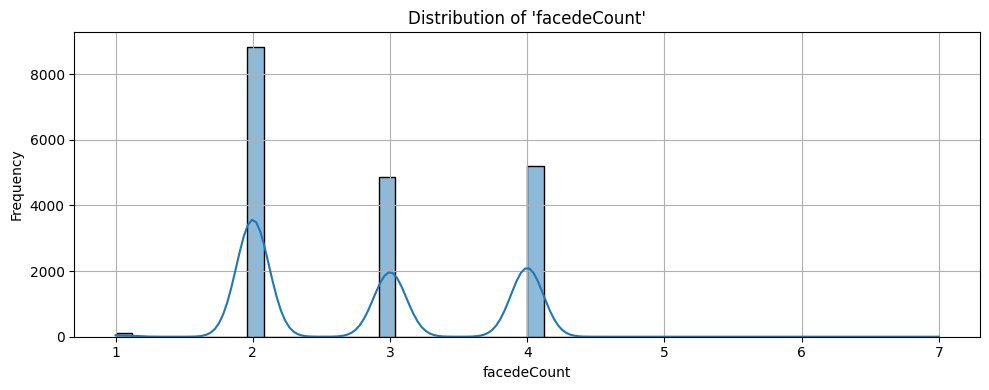

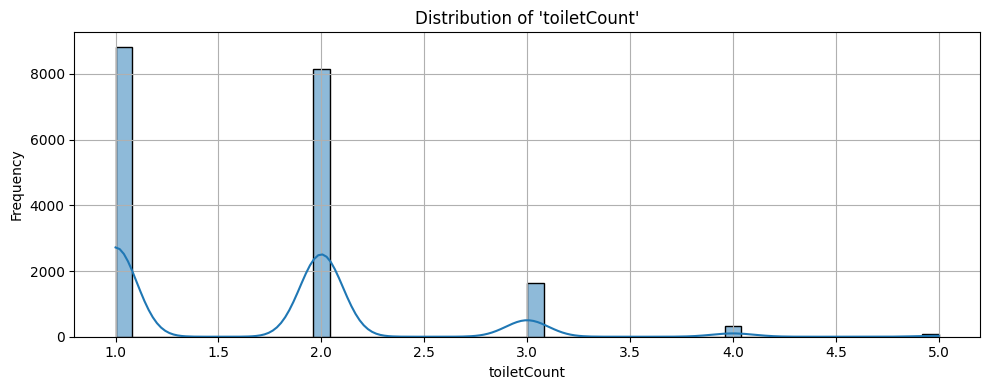

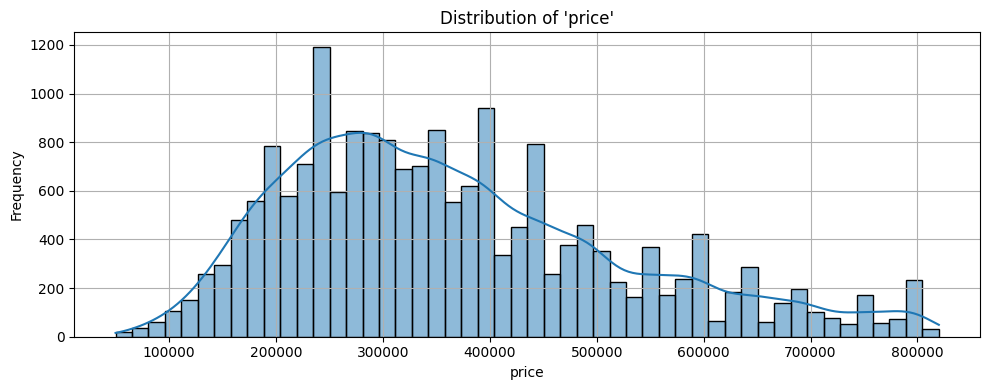

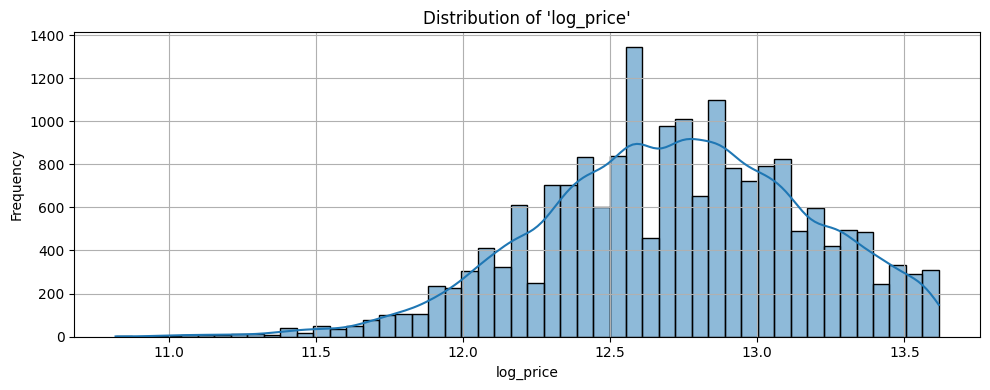

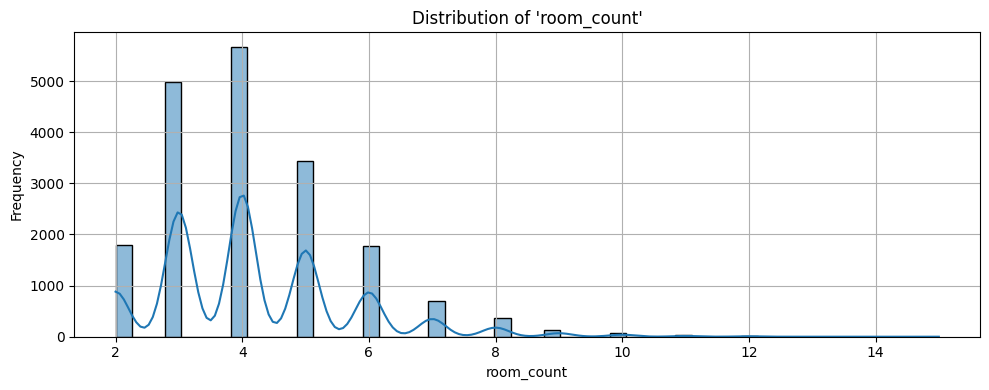

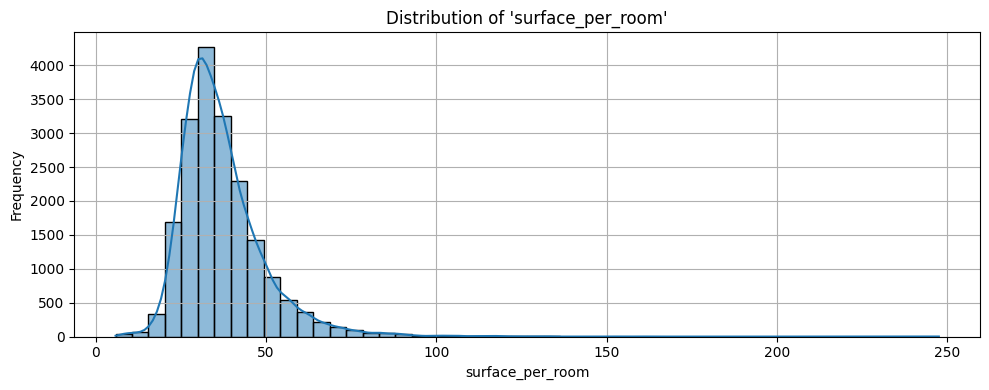

In [ ]:
# --- Distribution of numeric features ---
import matplotlib.pyplot as plt
import seaborn as sns

# Identifier les colonnes numériques disponibles
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"Numeric columns found: {numeric_cols}")


for col in numeric_cols:
    if df[col].dropna().nunique() > 1:  # Ignore les constantes ou colonnes vides
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col].dropna(), bins=50, kde=True)
        plt.title(f"Distribution of '{col}'")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
# --- Save cleaned DataFrame for ML ---
from datetime import datetime
from utils.data_cleaner import DataCleaner
from utils.constants import  CLEANED_DIR
import os


# Define timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Define output file path (cleaned folder + timestamped filename)
output_file = os.path.join(CLEANED_DIR, f"immoweb_real_estate_clean_for_ml{timestamp}.csv")

# Save the cleaned DataFrame
df.to_csv(output_file, index=False)

print(f"Cleaned dataset saved to: {output_file}")


Cleaned dataset saved to: e:\_SoftEng\_BeCode\real-estate-price-predictor\data\cleaned\immoweb_real_estate_cleaned_v2_20250628_0229.csv
